# Exploring Dandiset 001354: Hippocampal Responses to PAGER Activation

> **Note**: This notebook was generated with AI assistance. Please review all code and results carefully.

## Overview
This notebook introduces [DANDI:001354](https://dandiarchive.org/dandiset/001354/0.250312.0036), which contains intracellular electrophysiology recordings from mouse hippocampal CA1 neurons expressing programmable antigen-gated G-protein-coupled engineered receptors (PAGERs).

### Dataset Features
- Single-cell recordings from CA1 neurons
- Current clamp data showing responses to ramp stimuli
- 50 NWB files containing multiple sweeps per cell
- Supporting protocol publication in Nature

### Notebook Contents
1. Loading and examining NWB file structure
2. Exploring stimulus protocols and responses
3. Visualizing example sweeps and trial-to-trial variability
4. Tools for batch analysis across cells

## Required Packages

In [1]:
import pynwb
import h5py
import remfile
import numpy as np
import matplotlib.pyplot as plt
from dandi.dandiapi import DandiAPIClient
import pandas as pd
from itertools import islice

## Accessing the Dandiset
First, we'll use the DANDI API to examine available files:

In [2]:
# Initialize DANDI client
client = DandiAPIClient()
dandiset = client.get_dandiset("001354", "0.250312.0036")

# List the first 10 NWB assets to preview naming and structure
assets = dandiset.get_assets_by_glob("*.nwb")
asset_list = list(islice(assets, 10))

# Display file information
result = []
for asset in asset_list:
    result.append({
        'path': asset.path,
        'size_MB': round(asset.size / (1024*1024), 2)
    })
pd.DataFrame(result)

,path,size_MB
0,sub-PK-109/sub-PK-109_ses-20240717T180719_slic...,38.43
1,sub-PK-109/sub-PK-109_ses-20240717T150830_slic...,39.33
2,sub-PK-109/sub-PK-109_ses-20240717T184616_slic...,36.59
3,sub-PK-109/sub-PK-109_ses-20240717T164239_slic...,42.14
4,sub-PK-109/sub-PK-109_ses-20240717T155714_slic...,37.96
5,sub-PK-110/sub-PK-110_ses-20240723T173444_slic...,22.50
6,sub-PK-110/sub-PK-110_ses-20240723T195515_slic...,30.03
7,sub-PK-110/sub-PK-110_ses-20240723T143352_slic...,38.13
8,sub-PK-110/sub-PK-110_ses-20240723T185020_slic...,30.67
9,sub-PK-110/sub-PK-110_ses-20240723T160020_slic...,38.23


## Examining NWB File Structure
Let's load an example file and explore its organization:

In [3]:
# Load example NWB file
asset_path = 'sub-PK-109/sub-PK-109_ses-20240717T180719_slice-2024-07-17-0009_cell-2024-07-17-0009_icephys.nwb'
asset = next(dandiset.get_assets_by_glob(asset_path))

remote_file = remfile.File(asset.download_url)
h5_file = h5py.File(remote_file)
io = pynwb.NWBHDF5IO(file=h5_file, load_namespaces=True)
nwb = io.read()

# Extract key metadata
meta = {
    'session_description': nwb.session_description,
    'cell_id': nwb.lab_meta_data['DandiIcephysMetadata'].cell_id,
    'slice_id': nwb.lab_meta_data['DandiIcephysMetadata'].slice_id,
    'targeted_layer': nwb.lab_meta_data['DandiIcephysMetadata'].targeted_layer,
    'subject_id': nwb.subject.subject_id,
    'subject_sex': nwb.subject.sex,
    'subject_species': nwb.subject.species,
    'n_acquisition_series': len(nwb.acquisition),
    'n_stimulus_series': len(nwb.stimulus)
}

pd.Series(meta)

/opt/conda/lib/python3.11/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'core' version 2.8.0 because version 2.7.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


session_description     Intracellular electrophysiology experiment.
cell_id                                             2024_07_17_0009
slice_id                                            2024_07_17_0009
targeted_layer                                                  CA1
subject_id                                                   PK-109
subject_sex                                                       F
subject_species                                        Mus musculus
n_acquisition_series                                            624
n_stimulus_series                                               624
dtype: object

## Visualizing Stimulus-Response Data
We'll plot example sweeps showing both the stimulus current and resulting voltage response:

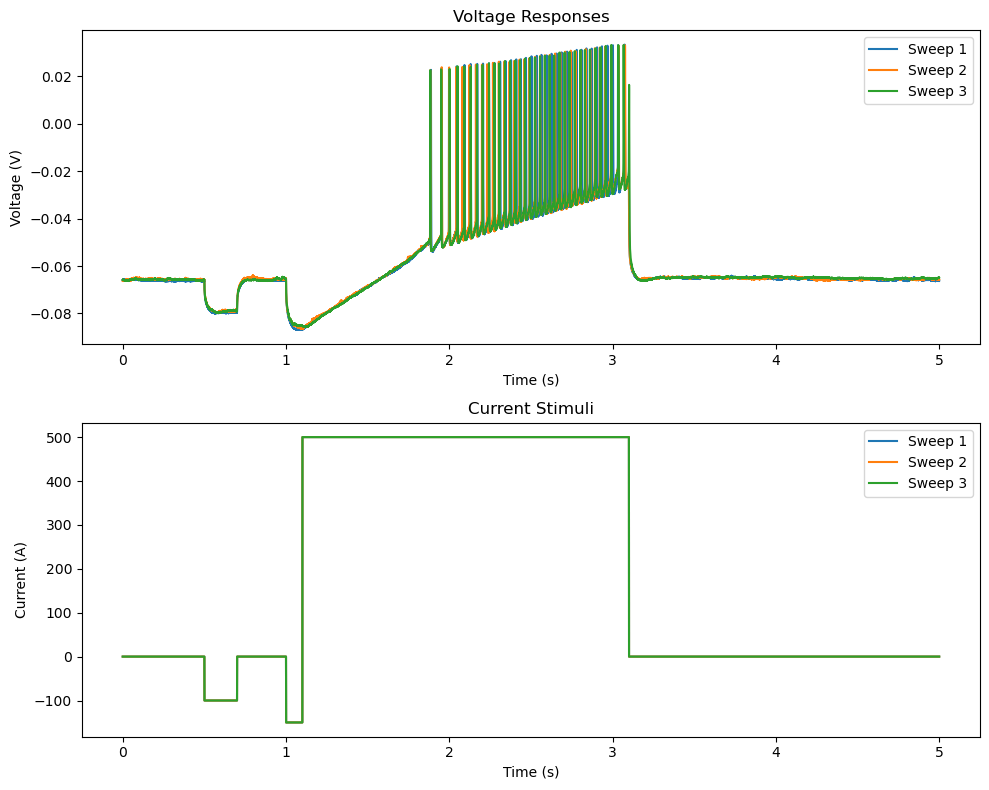

In [4]:
# Plot first 3 sweeps with full duration
n_sweeps = 3
responses = []
stimuli = []
time = None

for i in range(1, n_sweeps+1):
    stim_key = f'stimulus-{i:02d}-ch-0'
    resp_key = f'current_clamp-response-{i:02d}-ch-0'
    
    # Get stimulus and response data
    stim = nwb.stimulus[stim_key]
    resp = nwb.acquisition[resp_key]
    
    # Convert to physical units
    stim_data = stim.data[:]
    resp_data = resp.data[:] * resp.conversion
    
    stimuli.append(stim_data)
    responses.append(resp_data)
    
    if time is None:
        time = np.arange(len(stim_data)) / stim.rate + stim.starting_time

# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

# Plot responses
for i, r in enumerate(responses):
    ax1.plot(time, r, label=f'Sweep {i+1}')
ax1.set_title('Voltage Responses')
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Voltage (V)')
ax1.legend()

# Plot stimuli
for i, s in enumerate(stimuli):
    ax2.plot(time, s, label=f'Sweep {i+1}')
ax2.set_title('Current Stimuli')
ax2.set_xlabel('Time (s)')
ax2.set_ylabel('Current (A)')
ax2.legend()

plt.tight_layout()
plt.show()

## Trial-to-Trial Variability
Let's examine response consistency across multiple sweeps:

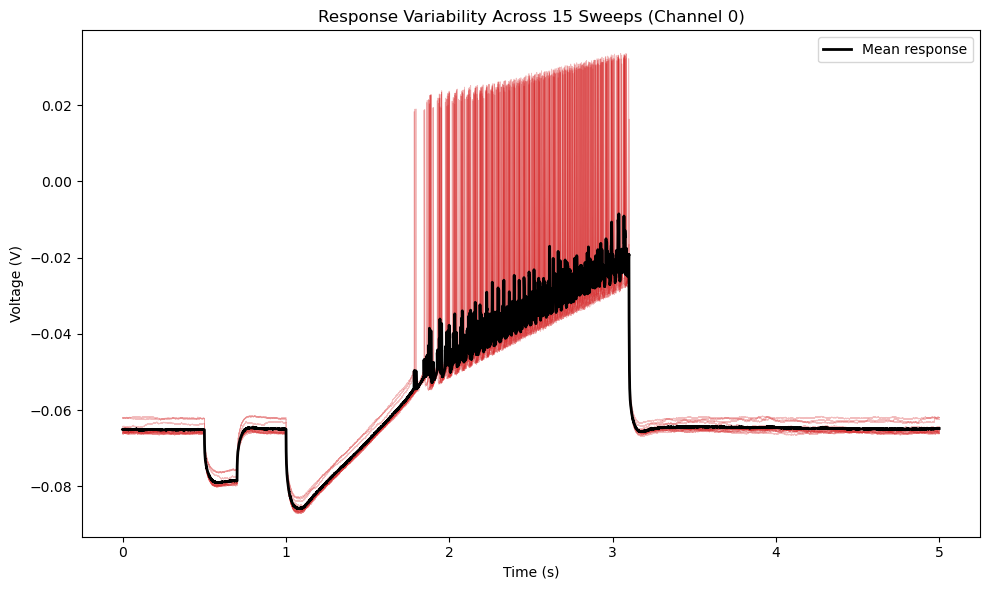

In [5]:
# Load first 15 sweeps
n_sweeps = 15
responses = []
stimuli = []

for i in range(1, n_sweeps+1):
    stim_key = f'stimulus-{i:02d}-ch-0'
    resp_key = f'current_clamp-response-{i:02d}-ch-0'
    stim = nwb.stimulus[stim_key]
    resp = nwb.acquisition[resp_key]
    stim_data = stim.data[:]
    resp_data = resp.data[:] * resp.conversion
    stimuli.append(stim_data)
    responses.append(resp_data)
    if time is None:
        time = np.arange(len(stim_data)) / stim.rate + stim.starting_time

responses = np.array(responses)
stimuli = np.array(stimuli)

# Plot overlaid responses
plt.figure(figsize=(10, 6))
for r in responses:
    plt.plot(time, r, color='tab:red', alpha=0.3, linewidth=0.6)
plt.plot(time, np.mean(responses, axis=0), color='black', label='Mean response', linewidth=2)
plt.title('Response Variability Across 15 Sweeps (Channel 0)')
plt.xlabel('Time (s)')
plt.ylabel('Voltage (V)')
plt.legend()
plt.tight_layout()
plt.show()

io.close()

## Examining Cell Properties
Let's check baseline membrane potential stability:

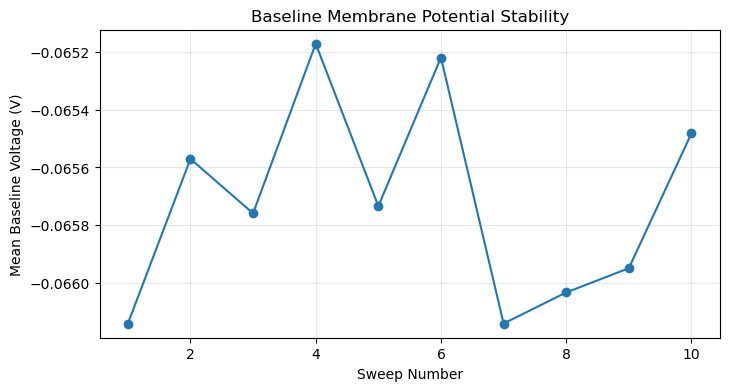

In [6]:
# Load a new file for this analysis
asset = next(dandiset.get_assets_by_glob(asset_path))
remote_file = remfile.File(asset.download_url)
h5_file = h5py.File(remote_file)
io = pynwb.NWBHDF5IO(file=h5_file, load_namespaces=True)
nwb = io.read()

# Calculate baseline membrane potential for first 10 sweeps
baseline_means = []
n_baseline_points = int(0.5 * 20000)  # 0.5 s at 20 kHz
for i in range(1, 11):
    resp = nwb.acquisition[f'current_clamp-response-{i:02d}-ch-0']
    data = resp.data[:n_baseline_points] * resp.conversion
    baseline_means.append(np.mean(data))

plt.figure(figsize=(8, 4))
plt.plot(range(1, 11), baseline_means, 'o-')
plt.xlabel('Sweep Number')
plt.ylabel('Mean Baseline Voltage (V)')
plt.title('Baseline Membrane Potential Stability')
plt.grid(True, alpha=0.3)
plt.show()

io.close()

## Next Steps
This dataset enables various analyses:
- Characterization of CA1 neuron responses to PAGER activation
- Comparison of response properties across cells
- Investigation of trial-to-trial variability
- Analysis of membrane potential dynamics during ramp stimuli

To adapt this code for your analysis:
1. Modify sweep selection criteria
2. Add custom response metrics
3. Extend to analyze multiple cells
4. Compare responses across experimental conditions